# GRIDtools area weighted volume test - comparing different zonal methods of precipitation across a watershed

Perform the necessary imports, GRIDtools install of v0.0.7 may still require you to set up an environment with the necessary dependencies.

In [1]:
import pynhd
from pathlib import Path
import geopandas as gpd
import rasterio as rio
import pandas as pd
import xarray as xr
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import xvec
from chmdata.thredds import GridMet, BBox
import os
#import GRIDtools as gt

In [2]:
pckg_path = Path('C:/Users/CNB968/OneDrive - MT/GitHub/GRIDtools/src/GRIDtools')
os.chdir(pckg_path)
from utils import RasterClass, find_intersections
from zonal import grid_area_weighted_volume, calc_zonal_stats
from watershed import delineate_watershed

Let's create a Geopandas GeoDataFrame of a couple of points within the Lolo Watershed in western Montana. Also, a "name" column is added to provide a unique ID to each point.

In [3]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Lolo_Catchment", "Bear_Creek_Catchment"]
    },
    geometry=[Point(-114.133170, 46.748808),
              Point(-114.324042, 46.766956)],
    crs=4326
)

Use GRIDtools delineate watershed function with the GeoDataFrame as input to get the drainage areas upstream of the points.

In [4]:
# Use delineate_watershed function to get polygon's of the contributing drainage area upstream of each point in GeoDataFrame
result = delineate_watershed(pour_pnt)
#result = gt.delineate_watershed(pour_pnt)

In [5]:
# view table
result

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,1,NaN,"POLYGON ((-114.35519 46.82845, -114.35519 46.8...",28.379194,Bear_Creek_Catchment,up,True,Bear Creek,24321310,17010205001011,"[-114.32473199573879, 46.76647114978662]"
1,0,NaN,"POLYGON ((-114.65629 46.739, -114.65629 46.739...",653.531430,Lolo_Catchment,up,True,Lolo Creek,24319270,17010205000088,"[-114.12979611165137, 46.747740712007136]"


You can see that the result returns another Geopandas GeoDataFrame that contains POLYGON geometries for the upstream drainage areas. The original uniqe ID (in this case the "name" column) is retained and additional attributes are returned including the Area in square Kilometers, the GNIS_name of the NHD segment that each point intersected, as well as its comid and reachcode. The catchmentID is NaN because it is a custom delineation so it does not conform to a known HUC. The intersection point is the flow direction trace intersection point from the original input point and where it intersected an NHD stream segment.

We can use Geopandas to visualize the output POLYGONs.

<Axes: >

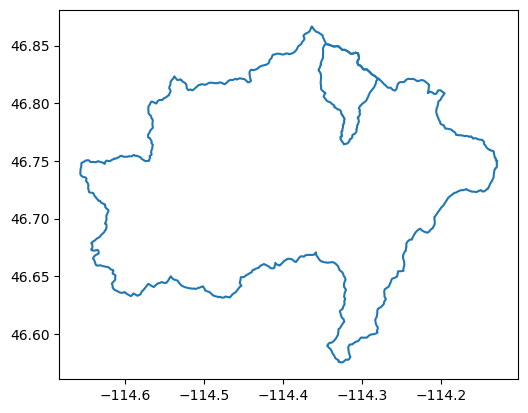

In [6]:
# plot watershed boundaries
result.boundary.plot()

## Get GridMET Precipitation Data

Next we will use DNRC's chmdata package to get some precipitation data for the delineated watersheds.

In [10]:
# Use chmdata to get GridMET precipitation data for the area of interest
# Create the bbox
bnds = result.total_bounds
bbox = BBox(bnds[0], bnds[2], bnds[3], bnds[1])
gmet = GridMet(variable='pr', start='2016-01-01', end='2024-12-01', bbox=bbox)
prcp = gmet.subset_nc(return_array=True)
# These lines of code fix some problems with GridMET's CRS attributes
#   FIX in chmdata so correct attributes are returned
geotrans = prcp.crs.GeoTransform.split(' ')
new_geotran = ' '.join([geotrans[0], geotrans[1], geotrans[2], geotrans[4], '0.0', geotrans[5]])
prcp['crs'] = prcp.crs.assign_attrs(crs_wkt=prcp.crs.attrs['spatial_ref'], GeoTransform=new_geotran)
# write the coordinate reference system
prcp = prcp.rio.write_crs(prcp.rio.crs)

In [ ]:
prcp.rio.reproject(5071)

This returns an xarray Dataset for the given bounding box. We can use Matplotlib to visulaize the grided data (in this case the total sum for the period requested 2016-01-01 to 2024-12-01).

In [8]:
# view cumulative precip over the time period
plt.imshow(prcp.precipitation_amount.sum(dim='time'))
plt.colorbar()

: 

: 

### Compare GRIDtools grid_area_weighted_volume() function with exactextract output

Reproject the precipitation data and basin geometries to a projected crs for area calculation in zonal stats packages.

In [21]:
prcp_proj = prcp.rename({'lat': 'y', 'lon': 'x'})
prcp_proj = prcp_proj.rio.reproject(5071)

In [23]:
geom_proj = result.to_crs(5071)

<Axes: title={'center': 'crs = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

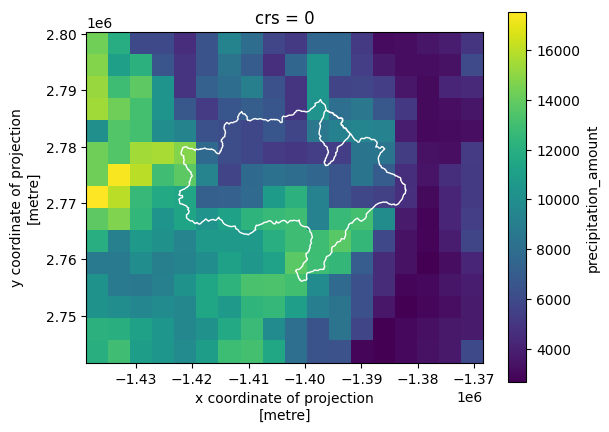

In [ ]:
graph_slice = prcp_proj.isel(x=slice(22,40), y=slice(30,45))
ax = plt.axes() 
graph_slice.precipitation_amount.sum(dim='time').plot(ax=ax)
geom_proj.plot(ax=ax, facecolor='None', edgecolor='white')
#plt.colorbar()

In [267]:
# based on rasterize
rastrz = prcp_proj.xvec.zonal_stats(geom_proj.loc[[0]].geometry, x_coords='x', y_coords='y', stats=['mean', 'count'], all_touched=True)
# exactextract algorithm
exac = prcp_proj.xvec.zonal_stats(geom_proj.loc[[0]].geometry, x_coords='x', y_coords='y', stats="sum(coverage_weight=area_cartesian)", method='exactextract')

c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


In [215]:
# Weighted raster of cell areas
cell_A = np.ones((prcp_proj.precipitation_amount.values.shape[1], prcp_proj.precipitation_amount.values.shape[2])) * (prcp_proj.rio.resolution()[0]**2)
cell_bounds = prcp_proj.rio.bounds()
cellA_crs = prcp_proj.rio.crs.wkt


In [218]:
import exactextract
Awghts = exactextract.raster.NumPyRasterSource(
    cell_A,
    xmin=cell_bounds[0],
    ymin=cell_bounds[1],
    xmax=cell_bounds[2],
    ymax=cell_bounds[3],
    nodata=np.nan,
    name='Cell_Areas',
    srs_wkt=cellA_crs
)
out = exactextract.exact_extract(prcp_proj, geom_proj, weights=Awghts, ops='weighted_sum', output='pandas')

c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


In [222]:
out.iloc[0,:366].sum()

np.float64(26676014.911342222)

Volume based on rasterize zonal statstics 'mean' times the count and area of each raster cell for year 2016 cumulative precipitation.

In [225]:
geom_proj.area[0]

np.float64(28379193.77677502)

In [268]:
rvol = rastrz.precipitation_amount.sel(zonal_statistics='mean') * geom_proj.area[0]
print(f"{rvol.sel(time=slice('2016-01-01', '2016-12-31')).sum().values} m^3")

25822859.066238187 m^3


Exactextract volume for year 2016 cumulative precipitation.

In [202]:
evol = exac.precipitation_amount.sel(time=slice('2016-01-01', '2016-12-31'))
print(f'{evol.sum().values} m^3')

26676014.89742582 m^3


In [94]:
prcp_proj.precipitation_amount.sel(time=slice('2016-01-01', '2016-12-31'))

<xarray.DataArray 'precipitation_amount' (time: 366, y: 74, x: 62)> Size: 13MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x                   (x) float64 496B -1.523e+06 -1.519e+06 ... -1.284e+06
  * y                   (y) float64 592B 2.916e+06 2.912e+06 ... 2.63e+06
  * time                (time) datetime64[ns] 3kB 2016-01-01 ... 2016-12-31
    latitude_longitude  int64 8B 0
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [ 61  98 231]

In [155]:
def zero_to_nd_indexer(index, rows, cols):
    tracker = 0
    i = 0
    j = 0
    for i in range(0, rows):
        if i > 0:
            tracker += 1
        j=0
        while j < cols-1:
            if tracker == index:
                break
            j += 1
            tracker += 1
        
        if tracker == index:
            break      
    
    return (i, j)

In [164]:
ex_rid = []
ex_cid = []
for i in out.iloc[0,0]:
    r, c = zero_to_nd_indexer(i, 74, 62)
    ex_rid.append(r)
    ex_cid.append(c)
ex_r = np.array(ex_rid)
ex_c = np.array(ex_cid)

In [235]:
prcp_proj.precipitation_amount.values[0,:,:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [247]:
msk = np.zeros((prcp_proj.precipitation_amount.shape[1], prcp_proj.precipitation_amount.shape[2]))
msk[ex_rid, ex_cid] = 1
ex_cells = prcp_proj.precipitation_amount[0,:,:]
ex_cells['precipitation_amount'] = (['y', 'x'], msk)

<Axes: title={'center': 'time = 2016-01-01, latitude_longitude = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

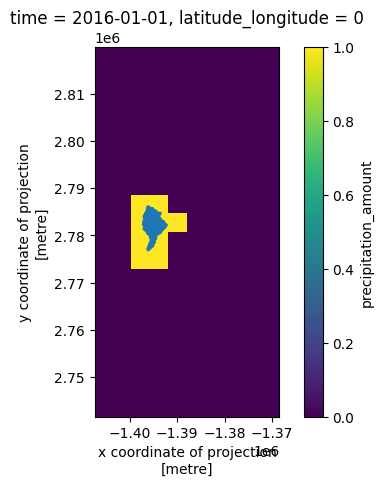

In [266]:
ax = plt.axes()
ex_cells[25:45, 30:40].precipitation_amount.plot(ax=ax)
geom_proj.loc[[0]].plot(ax=ax)

In [191]:
prcp_proj.precipitation_amount[:, ex_r, ex_c].max(dim='time')

<xarray.DataArray 'precipitation_amount' (y: 9, x: 9)> Size: 648B
array([[0.0463, 0.0402, 0.0463, 0.0402, 0.0404, 0.0463, 0.0402, 0.0463,
        0.0402],
       [0.0463, 0.0402, 0.0463, 0.0402, 0.0404, 0.0463, 0.0402, 0.0463,
        0.0402],
       [0.0364, 0.0382, 0.0364, 0.0382, 0.0416, 0.0364, 0.0382, 0.0364,
        0.0382],
       [0.0364, 0.0382, 0.0364, 0.0382, 0.0416, 0.0364, 0.0382, 0.0364,
        0.0382],
       [0.0364, 0.0382, 0.0364, 0.0382, 0.0416, 0.0364, 0.0382, 0.0364,
        0.0382],
       [0.0304, 0.0299, 0.0304, 0.0299, 0.0364, 0.0304, 0.0299, 0.0304,
        0.0299],
       [0.0304, 0.0299, 0.0304, 0.0299, 0.0364, 0.0304, 0.0299, 0.0304,
        0.0299],
       [0.0346, 0.0354, 0.0346, 0.0354, 0.0364, 0.0346, 0.0354, 0.0346,
        0.0354],
       [0.0346, 0.0354, 0.0346, 0.0354, 0.0364, 0.0346, 0.0354, 0.0346,
        0.0354]])
Coordinates:
  * x                   (x) float64 72B -1.398e+06 -1.394e+06 ... -1.394e+06
  * y                   (y) float64 72B 2.787e+06 2.787e+06 ... 2.775e+06
    latitude_longitude  int64 8B 0

CRS.from_epsg(5071)

In [180]:
prcp_proj.rio.resolution()

(3909.658450707694, -3909.6584507076977)

In [132]:
prcp_proj_i = prcp_proj.sel(time='2016-01-01')
prcp_proj_i.precipitation_amount[38, 52]

<xarray.DataArray 'precipitation_amount' ()> Size: 8B
array(0.)
Coordinates:
    x                   float64 8B -1.32e+06
    y                   float64 8B 2.767e+06
    time                datetime64[ns] 8B 2016-01-01
    latitude_longitude  int64 8B 0
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [ 61  98 231]

In [198]:
exac.precipitation_amount.sel(time=slice('2016-01-01', '2016-12-31'))

<xarray.DataArray 'precipitation_amount' (geometry: 1, time: 366)> Size: 3kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.02315814e+12, 5.67431236e+12, 2.53803457e+12,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.32143928e+12,
        3.90727044e+13, 5.56331989e+12, 0.00000000e+00, 1.87986114e+13,
        1.37581431e+13, 1.33101659e+13, 1.00657637e+13, 5.71532030e+12,
        5.92853960e+12, 3.92620042e+09, 1.33213085e+13, 4.09832042e+12,
        0.00000000e+00, 3.22842998e+12, 1.10883145e+13, 1.56788462e+13,
        1.97423768e+13, 1.15330032e+13, 1.77792467e+13, 1.47028008e+13,
        1.16002773e+13, 2.71117659e+12, 1.18419419e+13, 0.00000000e+00,
        4.67943645e+12, 4.51482966e+12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.33984540e+12, 1.17156340e+13, 2.45647566e+13,
        1.93617353e+13, 3.02629255e+13, 2.10716620e+13, 2.62990878e+12,
        2.54912816e+13, 1.59009106e+13, 1.33468807e+12, 9.16113431e+09,
        0.00000000e+00, 0.00000000e+00, 6.54366736e+09, 0.00000000e+00,
        1.14107133e+13, 1.80536568e+13, 1.01527915e+13, 0.00000000e+00,
        1.23496747e+13, 7.32453135e+11, 4.44481264e+12, 2.54247522e+12,
        1.19089364e+13, 6.89864962e+12, 5.35891148e+12, 2.36158463e+11,
        7.72137361e+12, 2.54733797e+13, 4.64829494e+12, 7.32890826e+12,
        3.44535882e+13, 1.98211359e+13, 2.39533061e+13, 1.85303629e+13,
        8.57445877e+12, 0.00000000e+00, 0.00000000e+00, 4.03072730e+12,
...
        4.56015845e+13, 3.58917440e+13, 2.09593611e+13, 1.84858518e+13,
        8.78996926e+12, 2.04873781e+13, 1.27455075e+13, 9.27336533e+12,
        0.00000000e+00, 0.00000000e+00, 1.50035828e+13, 1.20744924e+13,
        9.26959714e+12, 7.85240084e+09, 1.13819671e+13, 3.90232329e+13,
        2.89235997e+13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.83296596e+11, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.02928611e+12, 6.17954165e+11, 1.82366941e+13, 4.65449768e+13,
        1.23832348e+13, 0.00000000e+00, 0.00000000e+00, 4.08066642e+12,
        4.28482568e+12, 3.56755761e+12, 0.00000000e+00, 1.17715715e+13,
        5.23493389e+09, 0.00000000e+00, 0.00000000e+00, 5.21650783e+12,
        1.33342109e+13, 0.00000000e+00, 9.01662828e+12, 1.85990435e+13,
        8.48954877e+11, 2.99273588e+13, 3.31472984e+13, 3.27916570e+10,
        0.00000000e+00, 0.00000000e+00, 4.73240190e+12, 2.36918562e+13,
        2.05187509e+13, 3.19464363e+13, 9.21592312e+12, 0.00000000e+00,
        1.30998516e+13, 1.82688101e+13, 0.00000000e+00, 1.75320457e+12,
        5.35914361e+12, 1.55489270e+13, 3.21270641e+13, 0.00000000e+00,
        1.89885731e+12, 7.10556139e+12, 2.54200864e+13, 1.05174331e+12,
        0.00000000e+00, 2.82306853e+13, 7.31624796e+11, 7.32912220e+12,
        1.03098599e+13, 0.00000000e+00]])
Coordinates:
  * geometry  (geometry) object 8B POLYGON ((-1397414.0980813543 2784074.0633...
  * time      (time) datetime64[ns] 3kB 2016-01-01 2016-01-02 ... 2016-12-31
Indexes:
    geometry  GeometryIndex (crs=EPSG:5071)

In [64]:
rvol.sel(time=slice('2016-01-01', '2016-12-31'))

<xarray.DataArray (geometry: 1, time: 366)> Size: 3kB
array([[      0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,   12334.93227176,
         103305.05777601,   53965.32868896,       0.        ,
              0.        ,       0.        ,  100221.32470807,
         757056.46817945,  112556.25697984,       0.        ,
         359254.90241509,  275994.10958069,  269826.64344481,
         186565.85061041,  127974.92231954,  117181.85658175,
              0.        ,  248240.51196923,   84802.65936837,
              0.        ,   61674.66135881,  218945.04782379,
         316082.63946392,  373131.70122083,  222028.78089173,
         312998.90639598,  251324.24503717,  209693.84861997,
          44714.12948514,  237447.44623144,       0.        ,
          86344.52590234,   77093.32669852,       0.        ,
              0.        ,       0.        ,   74009.59363058,
         209693.84861997,  440973.82871552,  353087.43627921,
         547362.61955948,  387008.50002656,   52423.46215499,
         454850.62752126,  291412.7749204 ,   46255.99601911,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,  197358.91634821,
         334585.03787157,  180398.38447453,       0.        ,
...
              0.        ,       0.        ,       0.        ,
              0.        ,   10793.06573779,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,   55507.19522293,    9251.19920382,
         331501.30480363,  841859.12754782,  231279.98009555,
              0.        ,       0.        ,   77093.32669852,
          80177.05976646,   69383.99402867,       0.        ,
         215861.31475585,       0.        ,       0.        ,
              0.        ,   95595.72510616,  237447.44623144,
              0.        ,  174230.91833865,  353087.43627921,
          15418.6653397 ,  551988.21916139,  644500.21119961,
              0.        ,       0.        ,       0.        ,
          89428.25897028,  451766.89445332,  399343.43229832,
         627539.67932594,  181940.2510085 ,       0.        ,
         237447.44623144,  343836.23707539,       0.        ,
          35462.93028132,   97137.59164013,  291412.7749204 ,
         622914.07972403,       0.        ,   35462.93028132,
         132600.52192145,  461018.09365714,   21586.13147559,
              0.        ,  551988.21916139,   21586.13147559,
         132600.52192145,  197358.91634821,       0.        ]])
Coordinates:
  * time                (time) datetime64[ns] 3kB 2016-01-01 ... 2016-12-31
    latitude_longitude  int64 8B 0
    variable            <U20 80B 'precipitation_amount'
  * geometry            (geometry) object 8B POLYGON ((-1397414.0980813543 27...
Indexes:
    geometry  GeometryIndex (crs=EPSG:5071)

In [77]:
areas = exac.sel(time='2016-01-01').xvec.to_geodataframe(name='t1').geometry.area

In [80]:
areas.values

array([2.83791938e+07, 6.53531430e+08])

C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\3935042580.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(exac.time.values, exac.isel(geometry=i, variable=0).values * areas.values[i], marker=None, ls='solid', label=i, alpha=0.6)


Text(0, 0.5, 'Daily Precipitation Volume ($m^3$)')

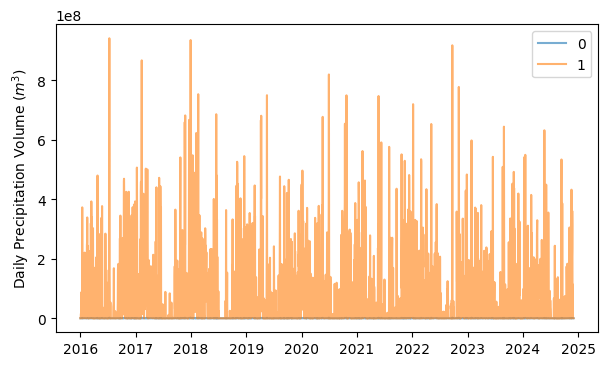

In [82]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
for i in range(len(exac.geometry.values)):
    ax.plot_date(exac.time.values, exac.isel(geometry=i, variable=0).values * areas.values[i], marker=None, ls='solid', label=i, alpha=0.6)
ax.legend()
ax.set_ylabel('Daily Precipitation Volume ($m^3$)')

Next we can use the precipitation_amount DataArray as input to the GRIDtools grid_area_weighted_volume function, along with our geometries of interest (in this case the output of the delineate watershed function), and then a specification of which column in the input GeoDataFrame we would like to use as location ID's in the resulting dataset.

In [98]:
class WeightedVolume():
    """
    Takes a multidimensional (.nc) DataArray and input polygon geometry in the same coordinate reference
    system and returns an area weighted volume for depth valued variables (e.g., precip).
    :param dataset: xarray.DataArray - must have defined spatial_ref and be in units of meters,
    time dimension/coords must be labeled 'time'
    :param in_geom: a GeoDataFrame of input shapefile/geometry in the same spatial_ref as xarray data
    :param out_fp: str - path to save shapefile if save_shp_to_file=True
    :param save_shp_to_file: boolean, default = False, if True will save the grid shapefile to the out filepath
    :return: xarray.Dataset - contains timeseries of area weighted volume for each input geometry.
    """
    def __init__(self, dataset, in_geom, geom_id_col=None, scale_data=1):
        self.dataset = dataset
        self.in_geom = in_geom
        self._geom_index = geom_id_col
        self.scale = scale_data

    def cal_weighted_zonal(self):
        if (self.in_geom.geom_type != 'Polygon').any():
            raise ValueError("The input geometry(s) are not all type Polygon. Only Polygons are supported.")

        #if self.dataset.rio.crs is None:
            #print("Input DataArray does not have a coordinate reference system, defaulting to WGS84.")
            #grd_crs = 4326
        #else:
            #grd_crs = self.dataset.rio.crs

        rast = RasterClass(self.dataset)
        grid_polys = gt.utils.vectorize_grid(self.dataset)
        grid_polys.index.name = 'GridID'
        nrows = rast.values.shape[1]
        ncols = rast.values.shape[2]

        g_proj = self.in_geom.to_crs(5071)
        grd_proj = grid_polys.to_crs(5071)
        self._grid = grd_proj

        # get in shape areas in Km^2
        ingeom_areas = g_proj.area.values / (1000 ** 2)

        clips = []
        for r in range(len(g_proj.index)):
            clpd = gpd.clip(grd_proj, g_proj.loc[[r]], sort=True)

            if self._geom_index is None:
                clpd['FeatureID'] = r
            elif self._geom_index in self.in_geom.columns.to_list():
                clpd['FeatureID'] = self.in_geom.loc[r][self._geom_index]
            else:
                raise ValueError("Argument for geom_id_col not found in input geometry columns.")
            clips.append(clpd)

        clipped_grid_shp = pd.concat(clips)
        clipped_grid_shp['CellArea_sqm'] = clipped_grid_shp.geometry.area
        clipped_grid_shp.index.name = 'GridID'
        self._clipped_grid = clipped_grid_shp

        # Loop through unique feature ID's calculate the weighted volume for each
        vol_series = []
        for gid in self.in_geom[self._geom_index].to_list():
            qarea = pd.DataFrame({'CellArea_sqm': clipped_grid_shp.loc[clipped_grid_shp['FeatureID'] == gid]['CellArea_sqm'].values},
                                index=clipped_grid_shp.loc[clipped_grid_shp['FeatureID'] == gid].index)
            allcells = pd.concat([qarea, grd_proj], axis=1)
            allcells.sort_index(inplace=True)
            self._allcells = allcells
            area_arry = allcells['CellArea_sqm'].values.reshape(nrows, ncols)
            md_arry = self.dataset.values / self.scale
            vol_grd = area_arry * md_arry
            vol_v = np.nansum(vol_grd, axis=(1, 2))
            vol_v = vol_v.reshape(vol_v.size, 1)
            vol_series.append(vol_v)

        # Create xarray dataset of result
        agg_dset = xr.Dataset(
            {
                "precip_volume": (
                ['time', 'location'], np.hstack(vol_series), {'standard_name': 'Area Weighted Precipitation Volume',
                                                            'units': 'm^3'}),
            },
            coords={
                "location": (['location'], self.in_geom[self._geom_index].to_list(), {'long_name': 'location_identifier',
                                                                            'cf_role': 'timeseries_id'}),
                "area": (['location'], ingeom_areas, {'standard_name': 'area',
                                                    'long_name': 'input_shape_area',
                                                    'units': 'km^2'}),
                "time": self.dataset.indexes['time']
            },
            attrs={
                "featureType": 'timeSeries'
            }
        )

        self.weighted_volumes = agg_dset

In [70]:
from affine import Affine
geotrans = prcp.crs.GeoTransform.split(' ')
aff = Affine.from_gdal(float(geotrans[0]), float(geotrans[1]), float(geotrans[2]), float(geotrans[4]), 0.0, float(geotrans[5]))
prcp = prcp.rio.write_transform(aff)
prcp = prcp.rio.write_crs(prcp.rio.crs)

In [99]:
test = WeightedVolume(prcp.precipitation_amount, result, geom_id_col='name', scale_data=1000)

In [100]:
test.dataset.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [101]:
test.cal_weighted_zonal()

In [102]:
test._clipped_grid[test._clipped_grid['FeatureID'] == 'Bear_Creek_Catchment']

,geometry,FeatureID,CellArea_sqm
GridID,,,
1495,"POLYGON ((-1395265.345 2784674.958, -1396882.9...",Bear_Creek_Catchment,2.143641e+06
1496,"POLYGON ((-1395265.345 2784674.958, -1395022.5...",Bear_Creek_Catchment,1.544188e+06
1556,"POLYGON ((-1395265.345 2784674.958, -1396149.6...",Bear_Creek_Catchment,7.052650e+06
1557,"POLYGON ((-1393440.727 2784319.027, -1393528.5...",Bear_Creek_Catchment,1.252579e+07
1558,"POLYGON ((-1392395.797 2782714.414, -1392363.2...",Bear_Creek_Catchment,4.697141e+05
1617,"POLYGON ((-1396149.653 2780146.986, -1396176.8...",Bear_Creek_Catchment,2.740079e+04
1618,"POLYGON ((-1394257.703 2779777.921, -1394258.2...",Bear_Creek_Catchment,4.615808e+06


In [110]:
prcp

<xarray.Dataset> Size: 89MB
Dimensions:               (lat: 56, lon: 61, time: 3258)
Coordinates:
  * lat                   (lat) float64 448B 47.86 47.82 47.78 ... 45.61 45.57
  * lon                   (lon) float64 488B -115.6 -115.6 ... -113.2 -113.1
  * time                  (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
    crs                   int64 8B 0
Data variables:
    precipitation_amount  (time, lat, lon) float64 89MB 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       27 January 2025
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [103]:
test.weighted_volumes.precip_volume.sel(location='Bear_Creek_Catchment', time=slice('2016-01-01', '2016-12-31')).sum()

<xarray.DataArray 'precip_volume' ()> Size: 8B
array(27872737.04161684)
Coordinates:
    location  <U20 80B 'Bear_Creek_Catchment'
    area      float64 8B 28.38

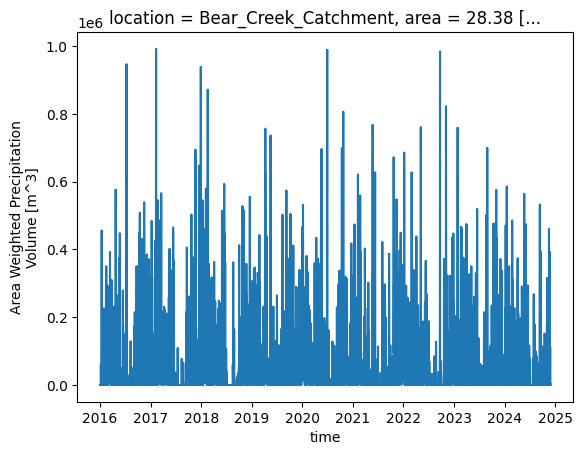

In [108]:
test.weighted_volumes.precip_volume.sel(location='Bear_Creek_Catchment').plot()

In [274]:
vol = gt.grid_area_weighted_volume(prcp.precipitation_amount / 1000, simp, geom_id_col='name')

Viewing the result we see that the output is another xarray Dataset that contains dimensions of time and location (polygons), there is a coordinate variable denoting the location ID, also a coordinate variable that contains the input polygon area in square kilometers.

The data variable of the output is the precip_volume in cubic meters.

In [228]:
vol

<xarray.Dataset> Size: 78kB
Dimensions:        (time: 3258, location: 2)
Coordinates:
  * location       (location) <U20 160B 'Bear_Creek_Catchment' 'Lolo_Catchment'
    area           (location) float64 16B 28.38 653.5
  * time           (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
Data variables:
    precip_volume  (time, location) float64 52kB 0.0 8.701e+04 ... 0.0 9.609e+04
Attributes:
    featureType:  timeSeries

In [275]:
vol.precip_volume.sel(location='Bear_Creek_Catchment', time=slice('2016-01-01', '2016-12-31')).sum()

<xarray.DataArray 'precip_volume' ()> Size: 8B
array(30529424.13999842)
Coordinates:
    location  <U20 80B 'Bear_Creek_Catchment'
    area      float64 8B 27.35

## Visualize the Results

C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\1750784007.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(vol.time.values, vol.precip_volume.sel(location=i).values, marker=None, ls='solid', label=i, alpha=0.6)
C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\1750784007.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(vol.time.values, vol.precip_volume.sel(location=i).cumsum().values, marker=None, ls='solid', label=i)
C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\1750784007.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(vol.time.values, vol.precip_volume.sel(location=i).cumsum().valu

Text(0, 0.5, 'Annual Total Precip Volume ($m^3$)')

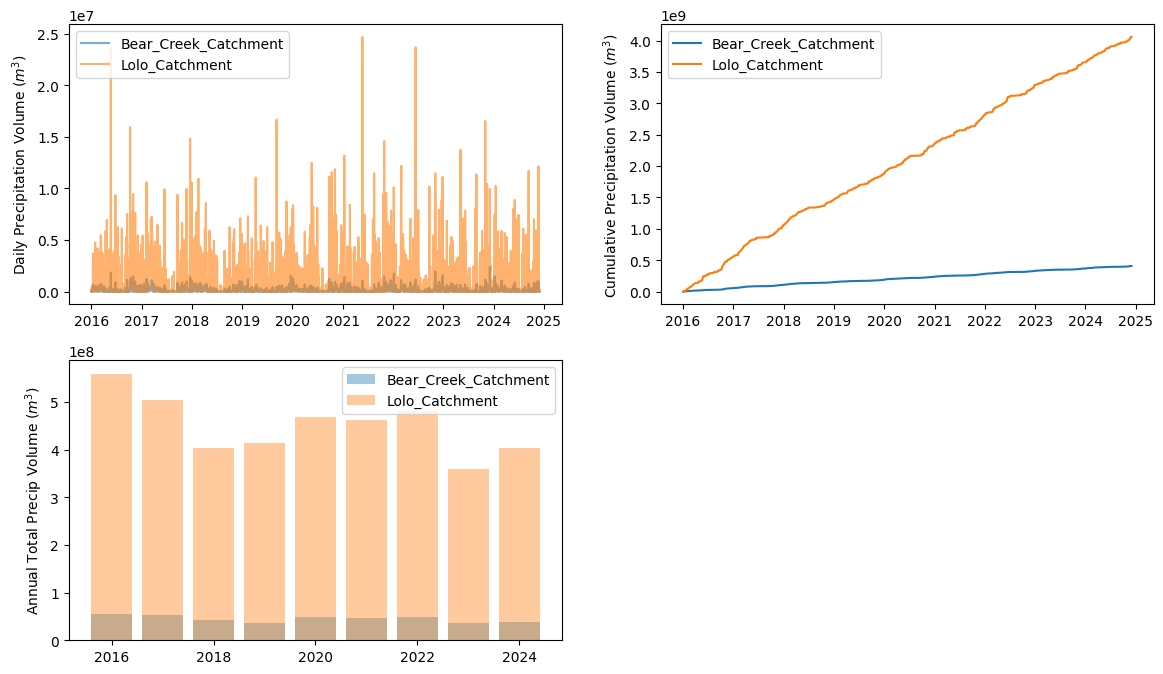

In [53]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
for i in vol.location.values:
    ax.plot_date(vol.time.values, vol.precip_volume.sel(location=i).values, marker=None, ls='solid', label=i, alpha=0.6)
ax.legend()
ax.set_ylabel('Daily Precipitation Volume ($m^3$)')
for i in vol.location.values:
    ax2.plot_date(vol.time.values, vol.precip_volume.sel(location=i).cumsum().values, marker=None, ls='solid', label=i)
ax2.legend()
ax2.set_ylabel('Cumulative Precipitation Volume ($m^3$)')
yr_resamp = vol.resample(time='YE').sum()
for i in vol.location.values:
    ax3.bar(yr_resamp.time.dt.year.values, yr_resamp.precip_volume.sel(location=i).values, label=i, alpha=0.4)
ax3.legend()
ax3.set_ylabel('Annual Total Precip Volume ($m^3$)')

In [9]:
from affine import Affine
geotrans = prcp.crs.GeoTransform.split(' ')
aff = Affine.from_gdal(float(geotrans[0]), float(geotrans[1]), float(geotrans[2]), float(geotrans[4]), 0.0, float(geotrans[5]))
prcp = prcp.rio.write_transform(aff)
prcp = prcp.rio.write_crs(prcp.rio.crs)
            

In [14]:
src = rio.open(r'D:\ArcGIS_Projects\Yellowstone\Upper Yellowstone\prms\MT_hydro_SRTM_30m_clipped.tif')
#r = RasterClass(prcp)

In [134]:
geotrans = prcp.crs.GeoTransform.split(' ')
new_geotran = ' '.join([geotrans[0], geotrans[1], geotrans[2], geotrans[4], '0.0', geotrans[5]])
prcp['crs'] = prcp.crs.assign_attrs(crs_wkt=prcp.crs.attrs['spatial_ref'], GeoTransform=new_geotran)

In [139]:
prcp.rio.write_crs(prcp.rio.crs)

<xarray.Dataset> Size: 89MB
Dimensions:               (lat: 56, lon: 61, time: 3258)
Coordinates:
  * lat                   (lat) float64 448B 47.86 47.82 47.78 ... 45.61 45.57
  * lon                   (lon) float64 488B -115.6 -115.6 ... -113.2 -113.1
  * time                  (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
    crs                   int64 8B 0
Data variables:
    precipitation_amount  (time, lat, lon) float64 89MB ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       28 January 2025
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [128]:
test.crs.attrs['spatial_ref']

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [132]:
test.crs.attrs['GeoTransform']

'-124.7666666333333 0.041666666666666 0.0 49.4 0.0 -0.041666666666666'

In [51]:
grid = gt.utils.vectorize_grid(prcp.precipitation_amount / 1000)

In [53]:
grid.index.name = 'GridID'

In [46]:
clips = []
for r in range(len(result.index)):
    clpd = gpd.clip(grid, result.loc[[r]], sort=True)
    clpd['name'] = result.loc[r]['name']
    clips.append(clpd)

In [4]:
basins = delineate_watershed(pour_pnt)

In [7]:
basins.rename_geometry()

TypeError: rename_geometry() missing 1 required positional argument: 'col'

In [6]:
def find_intersections(gdf: gpd.GeoDataFrame):
    """
    Function to find any intersecting geometries in a GeoDataFrame.

    Args:
        gdf(geopandas.GeoDataFrame): Input GeoDataFrame to assess intersections.

    Returns:
        geopandas.GeoDataFrame: Output GeoDataFrame
    """
    # Save geometries to another field
    gdf.loc[:,'geom'] = gdf.geometry

    # Self join
    sj = gpd.sjoin(gdf, gdf,
                   how="inner",
                   predicate="intersects",
                   lsuffix="left",
                   rsuffix="right")

    # Remove geometries that intersect themselves
    sj = sj[sj.index != sj.index_right]

    # Extract the intersecting geometry
    sj['intersection_geom'] = sj['geom_left'].intersection(sj['geom_right'])

    geom_name = sj.active_geometry_name
    # Reset the geometry (remember to set the CRS correctly!)
    sj = sj.set_geometry('intersection_geom', crs=gdf.crs)

    # Drop duplicate geometries
    final_gdf = sj.drop_duplicates(subset=['geometry']).reset_index()

    # Drop intermediate fields
    drops = ['geom_left', 'geom_right', 'index_right', 'index']
    final_gdf = final_gdf.drop(drops, axis=1)

    return final_gdf

In [9]:
test = find_intersections(basins)

<Axes: >

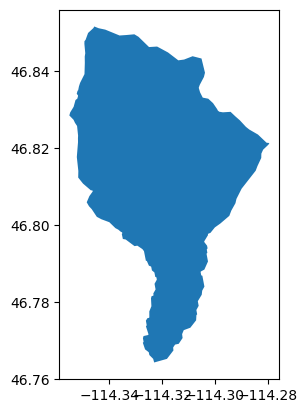

In [29]:
test.loc[[1]].plot()

In [37]:
basins.centroid.x.to_list()

C:\Users\CNB968\AppData\Local\Temp\ipykernel_15536\3669143387.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basins.centroid.x.to_list()


[-114.32104035821312, -114.3972281892955]

In [24]:
res = (5, -5)
yres = abs(res[1])
yres

5

In [3]:
in_tif = r'D:\ArcGIS_Projects\Yellowstone\Upper Yellowstone\prms\MT_hydro_SRTM_30m_clipped.tif'
in_grid = r'D:\ArcGIS_Projects\Yellowstone\Upper Yellowstone\prms\UY_Voronoi_Grid.shp'
in_md = r'D:\Spatial_Data\Statewide_Data\Raster\GridMET\Precip\pr_1996.nc'

In [4]:
prcp = xr.load_dataset(in_md)
geotrans = prcp.crs.GeoTransform.split(' ')
new_geotran = ' '.join([geotrans[0], geotrans[1], geotrans[2], geotrans[4], '0.0', geotrans[5]])
prcp['crs'] = prcp.crs.assign_attrs(crs_wkt=prcp.crs.attrs['spatial_ref'], GeoTransform=new_geotran)
# write the coordinate reference system
prcp = prcp.rio.write_crs(prcp.rio.crs, inplace=True)

In [4]:
calc_zonal_stats(in_grid, in_tif, all_touched=True, stats=['mean', 'count'])

C:\Users\CNB968\AppData\Local\Temp\ipykernel_18492\2685564782.py:1: UserWarning: Not all geometries were returned, 274 geometries were missed during rasterize. Attempting to rasterize missed geometries...
  calc_zonal_stats(in_grid, in_tif, all_touched=True, stats=['mean', 'count'])


Second attempt did not return all geometries, defaulting to point locations for remaining geometries.


Value
FID   Band stat              
0     1    count   946.000000
           mean   1808.949260
1     1    count    42.000000
           mean   1626.285714
2     1    count   607.000000
...                       ...
11120 1    mean   2956.889180
11121 1    count  9976.000000
           mean   2535.205694
11122 1    count  6815.000000
           mean   2624.970213

[22246 rows x 1 columns]

In [150]:
dimsizes = prcp.precipitation_amount.values.shape

In [151]:

for x in dimsizes:
    dimname = next((name for name, size in dict(prcp.sizes).items() if size == 1386), None)

366
585
1386


In [156]:
prcp['day'].values

array(['1996-01-01T00:00:00.000000000', '1996-01-02T00:00:00.000000000',
       '1996-01-03T00:00:00.000000000', '1996-01-04T00:00:00.000000000',
       '1996-01-05T00:00:00.000000000', '1996-01-06T00:00:00.000000000',
       '1996-01-07T00:00:00.000000000', '1996-01-08T00:00:00.000000000',
       '1996-01-09T00:00:00.000000000', '1996-01-10T00:00:00.000000000',
       '1996-01-11T00:00:00.000000000', '1996-01-12T00:00:00.000000000',
       '1996-01-13T00:00:00.000000000', '1996-01-14T00:00:00.000000000',
       '1996-01-15T00:00:00.000000000', '1996-01-16T00:00:00.000000000',
       '1996-01-17T00:00:00.000000000', '1996-01-18T00:00:00.000000000',
       '1996-01-19T00:00:00.000000000', '1996-01-20T00:00:00.000000000',
       '1996-01-21T00:00:00.000000000', '1996-01-22T00:00:00.000000000',
       '1996-01-23T00:00:00.000000000', '1996-01-24T00:00:00.000000000',
       '1996-01-25T00:00:00.000000000', '1996-01-26T00:00:00.000000000',
       '1996-01-27T00:00:00.000000000', '1996-01-28

In [148]:
next((name for name, size in dict(prcp.sizes).items() if size == 1386), None)


'lon'

In [139]:
prcp.precipitation_amount.values.shape

(366, 585, 1386)

In [16]:
raster = RasterClass(in_tif)
geom = gpd.read_file(in_grid)

In [15]:
r = RasterClass(prcp)

In [19]:
r.transform()

Affine(0.041666666666666, 0.0, -124.78749996666667,
       0.0, -0.041666666666666, 49.42083333333334)

In [10]:
from rasterio.features import rasterize
from rasterio.transform import rowcol
from rasterio.enums import MergeAlg
import warnings


def calc_zonal_stats(
        in_geom,
        in_grid,
        method='groupby',
        stats='mean',
        all_touched=False
    ):

    if isinstance(in_geom, (str, Path)):
        in_geom = gpd.read_file(in_geom)

    geom = in_geom
    raster = RasterClass(in_grid)

    # check crs
    if geom.crs.to_authority() == raster.crs.to_authority():
        pass
    else:
        geom = geom.to_crs(raster.crs)

    if isinstance(stats, str):
        stats=[stats]
    elif isinstance(stats, list):
        pass
    else:
        raise ValueError("stats argument must be either valid string or list of accepted methods")

    def rasterized_to_df(rasterized_features, in_raster_values, band_idx, stats):
        adj_rzd = rasterized_features-1
        rstrzd_df = pd.DataFrame({'FID': np.tile(adj_rzd.ravel(), band_idx.size), 'Band': band_idx.repeat(adj_rzd.ravel().size), 'Value': in_raster_values.ravel()})
        filtered_df = rstrzd_df.loc[rstrzd_df.FID != -1,:]
        grouped = filtered_df.groupby(['FID', 'Band']).agg({'Value': stats})
        Fstck = grouped.stack(level=1, future_stack=True)
        new_names = list(Fstck.index.names)[0:2] + ['stat']
        ret_df = Fstck.rename_axis(index=new_names)

        return ret_df
    

    bands = raster.values.shape[0]
    if raster.band_idx is None:
        band_idx = np.arange(1, bands+1)
    else:
        band_idx = raster.band_idx

    geom_value = ((geom, value) for geom, value in zip(geom.geometry, geom.index+1))
    rasterized = rasterize(
        geom_value,
        out_shape=(raster.values.shape[1], raster.values.shape[2]),
        fill=0,
        transform=raster.transform,
        all_touched=all_touched,
        dtype=np.int64,
        merge_alg=MergeAlg.replace
    )

    result_df = rasterized_to_df(rasterized, raster.values, band_idx, stats)

    n_rstrzed = np.unique(rasterized)
    gids = n_rstrzed[1:]-1
    if len(gids) != len(geom.index):
        warnings.warn(
            " ".join(
                [
                    f"Not all geometries were returned, {len(geom.index) - len(n_rstrzed[1:])} geometries were missed during rasterize.",
                     "Attempting to rasterize missed geometries..."
                ]
            ),
            UserWarning,
            stacklevel=2
        )

        missed_polys = geom.loc[~geom.index.isin(gids),:]

        geom_value = ((geom, value) for geom, value in zip(missed_polys.geometry, missed_polys.index+1))
        m_rasterized = rasterize(
            geom_value,
            out_shape=(raster.values.shape[1], raster.values.shape[2]),
            fill=0,
            transform=raster.transform,
            all_touched=all_touched,
            dtype=np.int64,
            merge_alg=MergeAlg.replace
        )
        
        m_result_df = rasterized_to_df(m_rasterized, raster.values, band_idx, stats)
        result_df = pd.concat([result_df, m_result_df])

        n_rstrzed = result_df.index.get_level_values(0).unique()
        if len(n_rstrzed) != len(geom.index):
            print("Second attempt did not return all geometries, defaulting to point locations for remaining geometries.")
        
            missed_polys = geom.loc[~geom.index.isin(n_rstrzed),:]
            cntrs = missed_polys.centroid
            rowcol_ids = rowcol(raster.transform, cntrs.x.to_list(), cntrs.y.to_list())
            point_values = raster.values[:,rowcol_ids[0], rowcol_ids[1]]
            point_rasterized = missed_polys.index.values
            pnt_df = rasterized_to_df(point_rasterized+1, point_values, band_idx, stats)

            result_df = pd.concat([result_df, pnt_df])

    if len(result_df.index.get_level_values(0).unique()) != len(geom.index):
        warnings.warn(f'Point locations failed to capture all geometries, {len(geom.index)-len(result_df.index.get_level_values(0).unique())} unrepresented geometries will be skipped...')

    result_df = result_df.sort_index(level=['FID', 'Band'])

    return result_df

In [6]:
elev = calc_zonal_stats(in_grid, in_tif, stats=['mean', 'count'])

C:\Users\CNB968\AppData\Local\Temp\ipykernel_27144\4112251082.py:1: UserWarning: Not all geometries were returned, 192 geometries were missed during rasterize. Attempting to rasterize missed geometries...
  elev = calc_zonal_stats(in_grid, in_tif, stats=['mean', 'count'])


Second attempt did not return all geometries, defaulting to point locations for remaining geometries.


In [11]:
precip = calc_zonal_stats(in_grid, prcp)

C:\Users\CNB968\AppData\Local\Temp\ipykernel_27144\502784789.py:1: UserWarning: Not all geometries were returned, 10540 geometries were missed during rasterize. Attempting to rasterize missed geometries...
  precip = calc_zonal_stats(in_grid, prcp)


Second attempt did not return all geometries, defaulting to point locations for remaining geometries.


C:\Users\CNB968\AppData\Local\Temp\ipykernel_27144\2129297100.py:100: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cntrs = missed_polys.centroid


In [14]:
junep = precip.xs('1996-06-01', level='Band')

In [17]:
geom['elevation'] = elev.xs('mean', level='stat').values.ravel()
geom['June 1 Precip'] = junep.values.ravel()

<Axes: >

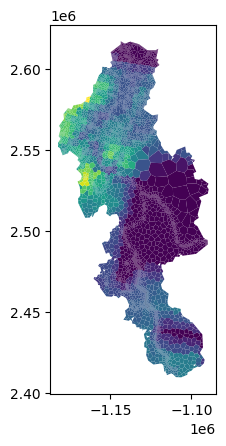

In [19]:
geom.plot(column='June 1 Precip')

In [91]:
rvals = raster.values[:,rowcol_ids[0], rowcol_ids[1]]
pidx = missed_polys.index.values
stats = ['mean', 'count']

In [92]:
_rasterized_to_df(pidx, rvals, np.arange(1, bands+1), stats)

Value
FID  Band stat         
911  1    mean   1534.0
          count     1.0
993  1    mean   1501.0
          count     1.0
1012 1    mean   1375.0
...                 ...
5007 1    count     1.0
5012 1    mean   1783.0
          count     1.0
5014 1    mean   1792.0
          count     1.0

[548 rows x 1 columns]

In [125]:
def arguments(**kwargs):
    if kwargs.get('layer') is not None:
        print("it worked")
    else:
        pass

arguments(stats=0)

In [28]:
adj_rzd = rasterized-1
rstrzd_df = pd.DataFrame({'FID': np.tile(adj_rzd.ravel(), bands), 'Band': np.arange(1, bands+1).repeat(adj_rzd.ravel().size), 'Value': raster.values.ravel()})

In [34]:
df = rstrzd_df.loc[rstrzd_df.FID != -1,:]
F = df.groupby(['FID', 'Band']).agg({'Value': ['mean', 'sum', pd.Series.mode]})

In [41]:
fin = F.stack(level=1, future_stack=True)


In [58]:
new_names = list(fin.index.names)

In [59]:
new_names = new_names[0:2] + ['stat']

In [70]:
Final = fin.rename_axis(index=new_names)

In [79]:
Final.index.get_level_values(0).unique()

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122],
      dtype='int64', name='FID', length=10849)

In [16]:
rasterized.ravel()
np.arange(1, bands+1).repeat(rasterized.ravel().size)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
n_rstrzed, counts = np.unique(rasterized, return_counts=True)
len(n_rstrzed[1:]) == len(large_polys.index)
gids = n_rstrzed[1:]-1

In [27]:
raster.values[:,rowcol_ids[0], rowcol_ids[1]]

array([[1638, 3007, 2871, 2359, 2366, 2362, 2360, 2359, 2360, 2360, 2360,
        2742, 2730, 1505, 2871, 2362, 2893, 2359, 2360, 2984, 2359, 2359,
        2360, 2360, 2360, 2359, 2360, 2998, 2910, 2359, 2367, 2360, 2359,
        2359, 2359, 2358, 2360, 2360, 3003, 1651, 1377, 2902, 2905, 2360,
        2359, 2365, 2360, 2360, 2358, 2359, 2359, 2360, 2360, 2360, 2360,
        3009, 1639, 1371, 2865, 2888, 2890, 2893, 1533, 1520, 2360, 2367,
        2363, 2360, 2360, 2359, 2359, 2358, 2360, 2360, 2360, 2360, 1645,
        3004, 1377, 1377, 2868, 2916, 2897, 2361, 2360, 2365, 2366, 2363,
        2360, 2360, 2359, 2358, 2360, 2360, 2360, 1651, 2871, 2866, 2872,
        2873, 2363, 2902, 2365, 2366, 2362, 2360, 2366, 2365, 2360, 2366,
        2367, 2365, 2366, 2365, 2358, 2359, 2360, 2360, 2362, 1651, 1645,
        1650, 2871, 2866, 2363, 2875, 2363, 2366, 2365, 2897, 2366, 2360,
        2366, 2363, 2365, 2366, 2367, 2360, 2358, 2362, 2360, 1648, 1651,
        1645, 2871, 2858, 2363, 2366, 

In [62]:
geom_value = ((geom, value) for geom, value in zip(large_polys.geometry, large_polys.index+1))
rasterized = rasterize(
    geom_value,
    out_shape=(raster.values.shape[1], raster.values.shape[2]),
    fill=0,
    transform=raster.transform,
    all_touched=True,
    dtype=np.int64,
    merge_alg=MergeAlg.replace
)

In [63]:
n_rstrzed, counts = np.unique(rasterized, return_counts=True)
len(n_rstrzed[1:]) == len(large_polys.index)

False

In [64]:
print(len(n_rstrzed[1:]))
print(len(large_polys.index))
print(f"Difference is {len(large_polys.index) - len(n_rstrzed[1:])}")

10778
10801
Difference is 23


In [65]:
gids = n_rstrzed[1:]-1
gids

array([    0,     1,     2, ..., 11120, 11121, 11122])

In [69]:
missed_polys = large_polys.loc[~large_polys.index.isin(gids),:]
small = missed_polys.loc[missed_polys.area < cell_area*6,:]
large = missed_polys.loc[~missed_polys.index.isin(small.index),:]

In [73]:
not small.empty

True

<Axes: >

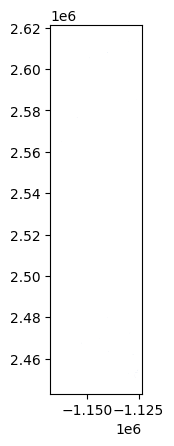

In [54]:
large_polys.loc[~large_polys.index.isin(gids),:].plot()